# CONFLUENCE Tutorial: Distributed Basin Workflow with Delineation

This notebook demonstrates the distributed modeling approach using the delineation method. We'll use the same Bow River at Banff location but create a distributed model with multiple GRUs (Grouped Response Units).

## Key Differences from Lumped Model

- **Domain Method**: `delineate` instead of `lumped`
- **Stream Threshold**: 5000 (creates more sub-basins)
- **Multiple GRUs**: Each sub-basin becomes a GRU
- **Routing**: mizuRoute connects the GRUs

## Learning Objectives

1. Understand watershed delineation with stream networks
2. Create a distributed model with multiple GRUs

## 1. Setup and Import Libraries

In [3]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import contextily as cx
import xarray as xr
from IPython.display import Image, display

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## Initialize CONFLUENCE
First, let's set up our directories and load the configuration. We'll modify the configuration from Tutorial 1 to create a distributed model.

In [4]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Load template configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update core paths
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Modify for distributed delineation
config_dict['DOMAIN_NAME'] = 'Bow_at_Banff_distributed'
config_dict['EXPERIMENT_ID'] = 'distributed_tutorial'
config_dict['EXPERIMENT_TIME_START'] = '2011-01-01 01:00'
config_dict['EXPERIMENT_TIME_END'] = '2022-01-01 01:00'
config_dict['DOMAIN_DEFINITION_METHOD'] = 'delineate'  # Changed from 'lumped'
config_dict['STREAM_THRESHOLD'] = 5000  # Higher threshold for fewer sub-basins
config_dict['DOMAIN_DISCRETIZATION'] = 'GRUs'  # Keep as GRUs
config_dict['SPATIAL_MODE'] = 'Distributed'  # Changed from 'Lumped'

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_distributed.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Domain Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {confluence.config['STREAM_THRESHOLD']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

18:37:56 - INFO - ============================================================


2025-05-14 18:37:56,852 - confluence_general - INFO - ============================================================


18:37:56 - INFO - CONFLUENCE Logging Initialized


2025-05-14 18:37:56,854 - confluence_general - INFO - CONFLUENCE Logging Initialized


18:37:56 - INFO - Domain: Bow_at_Banff_distributed


2025-05-14 18:37:56,856 - confluence_general - INFO - Domain: Bow_at_Banff_distributed


18:37:56 - INFO - Experiment ID: distributed_tutorial


2025-05-14 18:37:56,858 - confluence_general - INFO - Experiment ID: distributed_tutorial


18:37:56 - INFO - Log Level: INFO


2025-05-14 18:37:56,859 - confluence_general - INFO - Log Level: INFO


18:37:56 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250514_183756.log


2025-05-14 18:37:56,861 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250514_183756.log


18:37:56 - INFO - ============================================================


2025-05-14 18:37:56,862 - confluence_general - INFO - ============================================================


18:37:56 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250514_183756.yaml


2025-05-14 18:37:56,884 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250514_183756.yaml


18:37:56 - INFO - Initializing CONFLUENCE system


2025-05-14 18:37:56,888 - confluence_general - INFO - Initializing CONFLUENCE system


18:37:56 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


2025-05-14 18:37:56,890 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


18:37:56 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-14 18:37:56,891 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


18:37:57 - INFO - CONFLUENCE system initialized successfully


2025-05-14 18:37:57,230 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_distributed
Pour Point: 51.1722/-115.5717
Domain Method: delineate
Stream Threshold: 5000
Spatial Mode: Distributed
Model: SUMMA
Simulation Period: 2011-01-01 01:00 to 2022-01-01 01:00


## Project Setup - Organizing the Modeling Workflow

 We establish the project structure, similar to what we did in Tutorial 1.

In [5]:
# Project Initialization

project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

18:38:07 - INFO - Setting up project for domain: Bow_at_Banff_distributed


2025-05-14 18:38:07,005 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_distributed


18:38:07 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed


2025-05-14 18:38:07,350 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed
2025-05-14 18:38:07,508 - pyogrio._io - INFO - Created 1 records


18:38:07 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp


2025-05-14 18:38:07,512 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_distributed
  📁 attributes
  📁 documentation
  📁 forcing
  📁 observations
  📁 optimisation
  📁 plots
  📁 settings
  📁 shapefiles
  📁 simulations


## Geospatial Domain Definition - Data Acquisition and Preparation

We'll reuse some of the geospatial data from the lumped model tutorial, where appropriate.

In [ ]:
# Check if we can reuse data from the lumped model
lumped_dem_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped_tutorial' / 'attributes' / 'elevation' / 'dem'
lumped_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped_tutorial' / 'forcing' / 'raw_data'
can_reuse = lumped_dem_path.exists()
can_reuse_forcing = lumped_forcing_path.exists()

if can_reuse or can_reuse_forcing:
    import shutil
    
    # Create a function to copy files with name substitution
    def copy_with_name_substitution(src_path, dst_path, old_str='_lumped', new_str='_distributed'):
        if not src_path.exists():
            return False
            
        # Create destination directory if it doesn't exist
        dst_path.parent.mkdir(parents=True, exist_ok=True)
        
        if src_path.is_dir():
            # Copy entire directory
            if not dst_path.exists():
                dst_path.mkdir(parents=True, exist_ok=True)
                
            # Copy all files with name substitution
            for src_file in src_path.glob('**/*'):
                if src_file.is_file():
                    # Create relative path
                    rel_path = src_file.relative_to(src_path)
                    # Create new filename with substitution
                    new_name = src_file.name.replace(old_str, new_str)
                    # Create destination path
                    dst_file = dst_path / rel_path.parent / new_name
                    # Create parent directories if they don't exist
                    dst_file.parent.mkdir(parents=True, exist_ok=True)
                    # Copy the file
                    shutil.copy2(src_file, dst_file)
            return True
        elif src_path.is_file():
            # Copy single file with name substitution
            new_name = dst_path.name.replace(old_str, new_str)
            dst_file = dst_path.parent / new_name
            dst_file.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src_path, dst_file)
            return True
        
        return False

    print("Found existing geospatial data from lumped model. Copying and renaming files...")
    
    # Copy and rename DEM and other attribute data
    if can_reuse:
        # Define paths
        src_attr_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped_tutorial' / 'attributes'
        dst_attr_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed' / 'attributes'
        
        # Copy attributes with name substitution
        copied = copy_with_name_substitution(src_attr_path, dst_attr_path, '_lumped_tutorial', '_distributed')
        if copied:
            print("✓ Copied and renamed attribute files from lumped model")
    
    # Copy and rename forcing data
    if can_reuse_forcing:
        # Define paths
        src_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped_tutorial' / 'forcing' / 'raw_data'
        dst_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_distributed' / 'forcing' / 'raw_data'
         
        # Copy forcing data with name substitution
        copied = copy_with_name_substitution(src_forcing_path, dst_forcing_path, '_lumped_tutorial', '_distributed')
        if copied:
            print("✓ Copied and renamed forcing data from lumped model")
            
    print("The distributed model will use these copied files as a starting point.")
else:
    print("No existing data found from the lumped model. Will acquire all data from scratch.")

    # Step 2: Geospatial Domain Definition - Data Acquisition
    print("\n=== Step 2: Geospatial Domain Definition - Data Acquisition ===")
    
    # Acquire attributes
    print("Acquiring geospatial attributes (DEM, soil, land cover)...")
    confluence.managers['data'].acquire_attributes()

    # Acquire forcings
    print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
    confluence.managers['data'].acquire_forcings()
    
print("\n✓ Geospatial attributes acquired")

## Geospatial Domain Definition - Delineation with Stream Network

This is where the main difference occurs - we'll create multiple sub-basins connected by a stream network.

In [ ]:
# Step 3: Geospatial Domain Definition - Delineation
print("=== Step 3: Geospatial Domain Definition - Delineation ===")

# Define domain
print(f"Delineating distributed watershed...")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream threshold: {confluence.config['STREAM_THRESHOLD']}")
print("\nThis will create multiple sub-basins connected by a stream network.")

watershed_path = confluence.managers['domain'].define_domain()

# Check outputs
basin_path = project_dir / 'shapefiles' / 'river_basins'
network_path = project_dir / 'shapefiles' / 'river_network'

if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    print(f"\n✓ Created basin shapefiles: {len(basin_files)}")
    
if network_path.exists():
    network_files = list(network_path.glob('*.shp'))
    print(f"✓ Created river network shapefiles: {len(network_files)}")
    
    # Load and check number of basins
    if basin_files:
        gdf = gpd.read_file(basin_files[0])
        print(f"\nNumber of sub-basins (GRUs): {len(gdf)}")
        print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")

## 7. Visualize the Distributed Domain

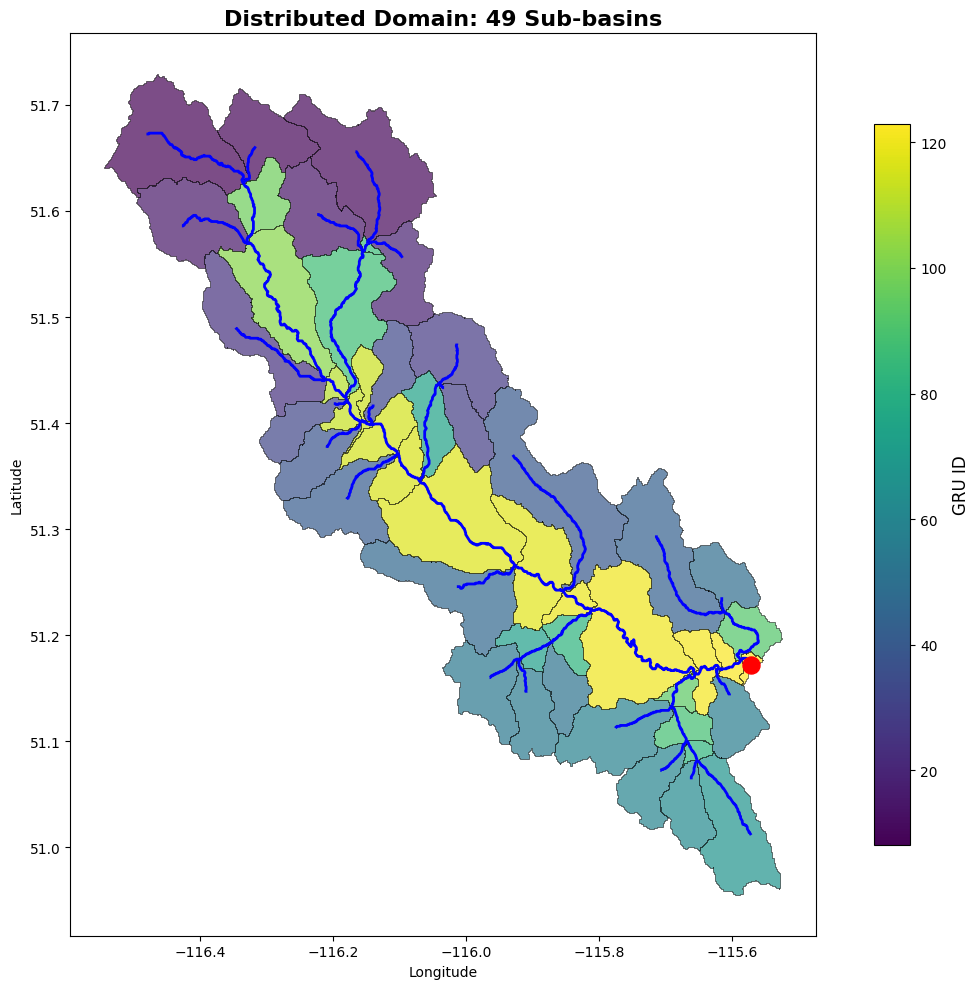

In [14]:
# Visualize the delineated domain with stream network
basin_files = list((project_dir / 'shapefiles' / 'river_basins').glob('*.shp'))
network_files = list((project_dir / 'shapefiles' / 'river_network').glob('*.shp'))
    
if basin_files and network_files:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Load data
    basins = gpd.read_file(basin_files[0])
    rivers = gpd.read_file(network_files[0])
    
    # Plot basins with different colors
    basins.plot(ax=ax, column='GRU_ID', cmap='viridis', 
               alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Plot river network
    rivers.plot(ax=ax, color='blue', linewidth=2)
    
    # Add pour point
    pour_point = gpd.read_file(pour_point_path)
    pour_point.plot(ax=ax, color='red', markersize=150, marker='o', zorder=5)
    
    ax.set_title(f'Distributed Domain: {len(basins)} Sub-basins', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar for GRU IDs
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=basins['GRU_ID'].min(), 
                                                 vmax=basins['GRU_ID'].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('GRU ID', fontsize=12)
    
    plt.tight_layout()
    plt.show()

## Geospatial Domain Definition - Discretization

Now we'll create Hydrologic Response Units (HRUs) based on the Grouped Response Units (GRUs) we just created.

In [ ]:
# Geospatial Domain Definition - Discretization

print(f"Creating HRUs based on GRUs...")
print(f"Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print("For this tutorial: 1 GRU = 1 HRU (simplest case)")

hru_path = confluence.managers['domain'].discretize_domain()

# Check the created HRU shapefile
catchment_path = project_dir / 'shapefiles' / 'catchment'
if catchment_path.exists():
    hru_files = list(catchment_path.glob('*.shp'))
    print(f"\n✓ Created HRU shapefiles: {len(hru_files)}")
    
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        print(f"\nHRU Statistics:")
        print(f"Number of HRUs: {len(hru_gdf)}")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")
        
        # Show HRU distribution
        hru_counts = hru_gdf.groupby('GRU_ID').size()
        print(f"\nHRUs per GRU:")
        for gru_id, count in hru_counts.items():
            print(f"  GRU {gru_id}: {count} HRUs")

## Model Agnostic Data Processing - Observed Data

The observed streamflow data will be the same for both the lumped and distributed models since they use the same pour point.

In [ ]:
# Model Agnostic Data Processing - Observed Data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

## Model Agnostic Data Processing - Preprocessing

In [ ]:
# Model Agnostic Data Processing - Preprocessing
print("\nRunning model-agnostic preprocessing...")

confluence.managers['data'].run_model_agnostic_preprocessing()

print("\n✓ Model-agnostic preprocessing completed")

## Model-Specific Processing - Preprocessing

Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case), set up for a distributed configuration.

In [ ]:
# Model Specific Processing and Initialization

print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
print(f"Note: For distributed mode with {confluence.config['HYDROLOGICAL_MODEL']}, this includes generating:")
print(f"  - Model parameter files for each GRU")
print(f"  - Routing configuration for river network")

confluence.managers['model'].preprocess_models()

print("\n✓ Model-specific preprocessing completed")

## Run the Distributed Model

Now we execute the SUMMA model in distributed mode with routing.

In [ ]:
# Run the Distributed Model
print("Note: This will take longer than the lumped model due to multiple units.")

confluence.managers['model'].run_models()

print("\n✓ Model execution completed")

## Visualize Distributed Model Results

Loading simulation data from: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/simulations/distributed_tutorial/mizuRoute/distributed_tutorial.h.2011-01-01-03600.nc
Loading observation data from: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv
Observation period: 2011-01-01 00:00:00 to 2023-12-31 00:00:00
Using reach ID for outlet: 123
Common data period: 2011-02-01 00:00:00 to 2022-01-01 00:00:00
Performance metrics:
  - RMSE: 37.83 m³/s
  - NSE: 0.33
  - PBIAS: -25.29%
  - KGE: 0.46
Plot saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/results/distributed_tutorial_streamflow_comparison.png


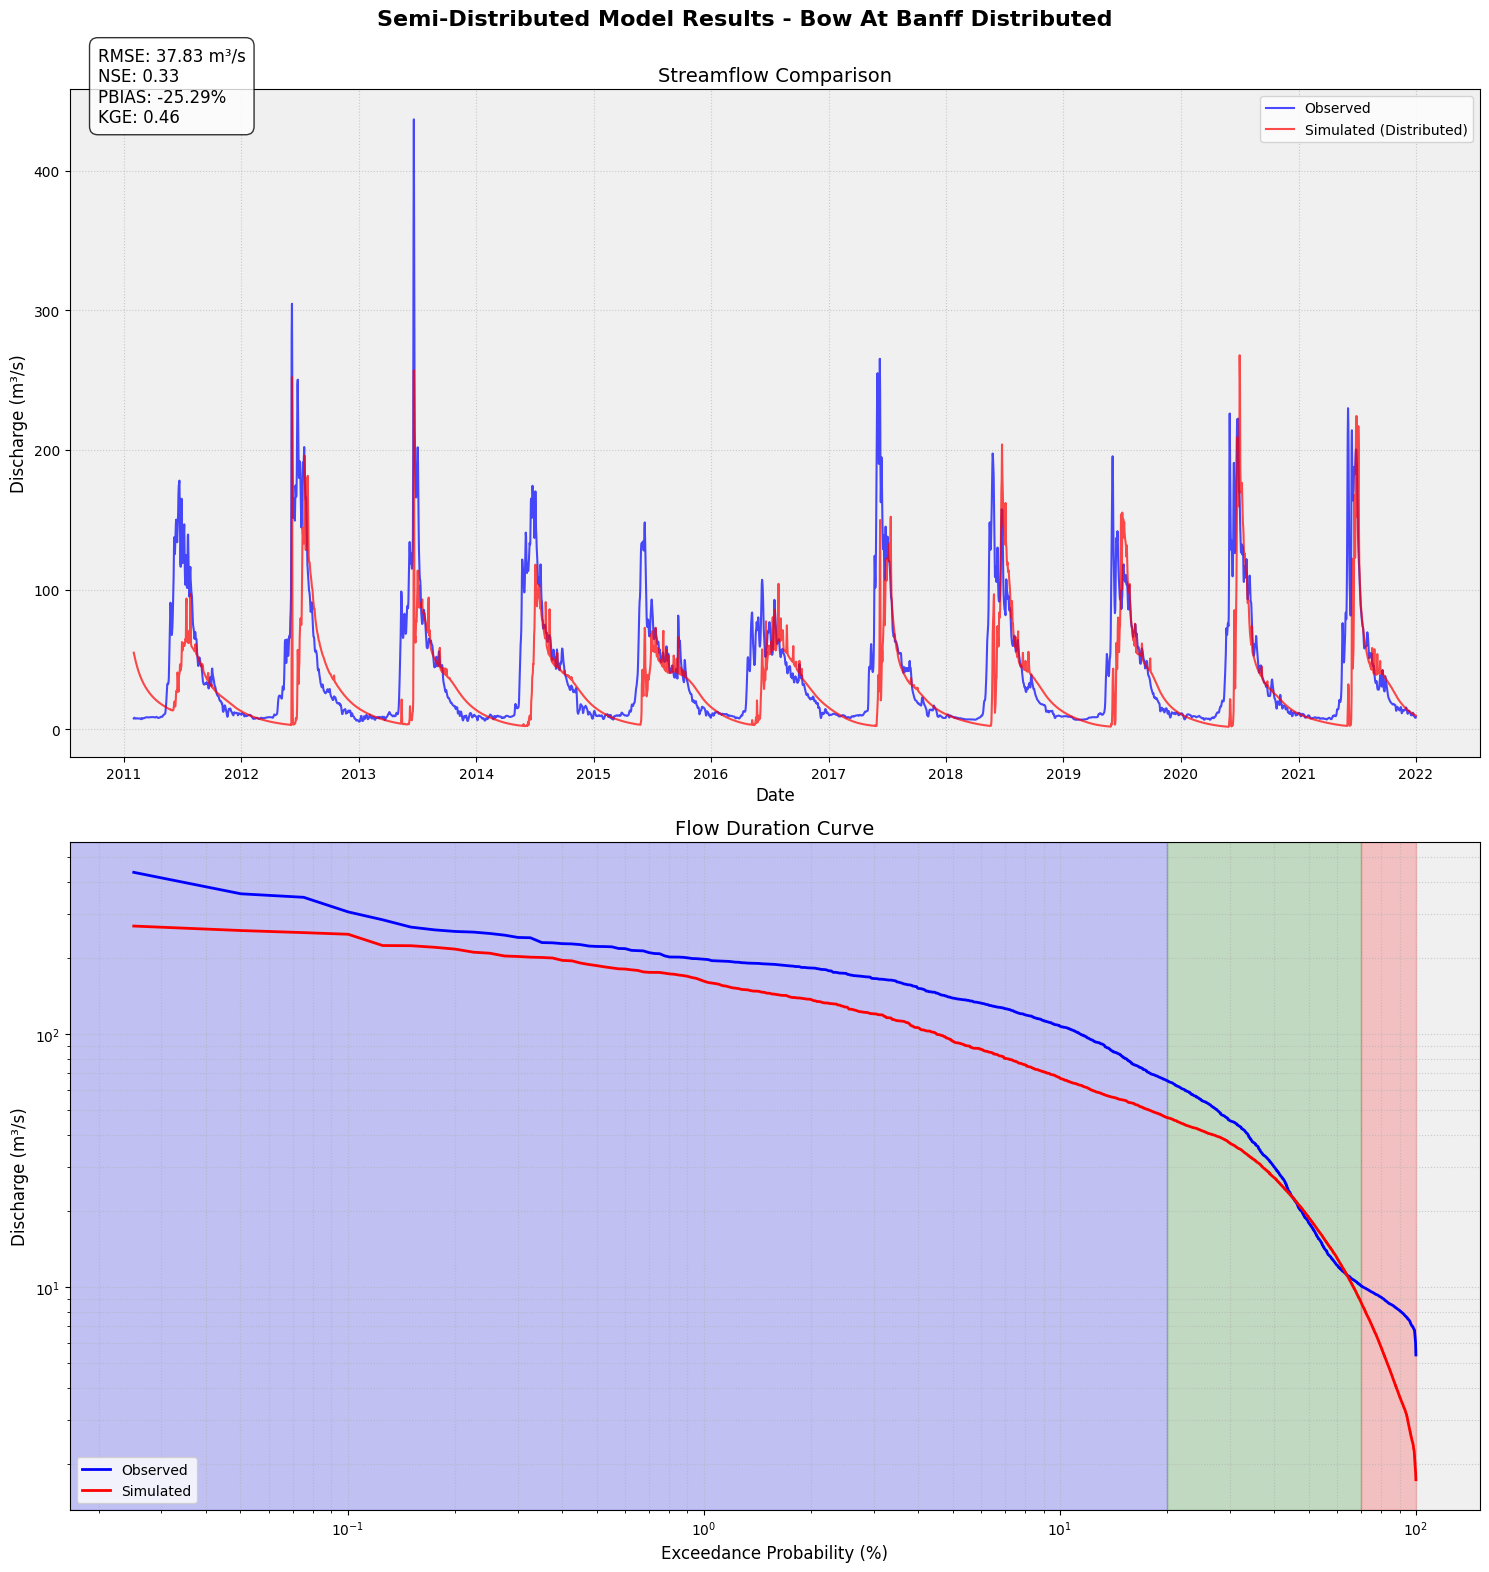

In [6]:
# Visualize Observed vs. Simulated Streamflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import matplotlib.dates as mdates
from pathlib import Path

# Load and plot simulation results
sim_path = project_dir / 'simulations' / confluence.config['EXPERIMENT_ID'] / 'mizuRoute'
sim_files = list(sim_path.glob('*.nc'))

# Load simulation data
print(f"Loading simulation data from: {sim_files[0]}")
sim_data = xr.open_dataset(sim_files[0])

# Load observation data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"

if not obs_path.exists():
    print(f"Warning: Observation data not found at expected path: {obs_path}")
    print("Checking for alternative locations...")
    alt_obs_paths = list(Path(config_dict['CONFLUENCE_DATA_DIR']).glob(
        f"domain_{config_dict['DOMAIN_NAME']}/observations/streamflow/preprocessed/*_streamflow_processed.csv"))
    
    if alt_obs_paths:
        obs_path = alt_obs_paths[0]
        print(f"Found alternative observation data at: {obs_path}")
    else:
        print("No observation data found. Only simulations will be displayed.")

if obs_path.exists():
    print(f"Loading observation data from: {obs_path}")
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    obs_df.set_index('datetime', inplace=True)
    print(f"Observation period: {obs_df.index.min()} to {obs_df.index.max()}")
else:
    obs_df = None
    
# Find the segment ID for the outlet
reach_id = int(confluence.config.get('SIM_REACH_ID', 0))
print(f"Using reach ID for outlet: {reach_id}")

# Find the index where reachID matches the target reach_id
segment_indices = np.where(sim_data.reachID.values == reach_id)[0]

if len(segment_indices) == 0:
    print(f"Error: Reach ID {reach_id} not found in simulation data")
    print(f"Available reach IDs: {sim_data.reachID.values}")
else:
    # Extract flow at the outlet segment using the index
    segment_index = segment_indices[0]
    sim_flow = sim_data.IRFroutedRunoff.isel(seg=segment_index).to_series()
    sim_df = pd.DataFrame(sim_flow)
    sim_df.columns = ['discharge_cms']

    # Determine common time period if observations exist
    if obs_df is not None:
        # Align to daily timestep for comparison
        obs_daily = obs_df.resample('D').mean()
        sim_daily = sim_df.resample('D').mean()
        
        # Find overlapping time period
        start_date = max(obs_daily.index.min(), sim_daily.index.min())
        end_date = min(obs_daily.index.max(), sim_daily.index.max())
        
        # Advance start date by 1 month to skip initial spinup
        start_date = start_date + pd.DateOffset(months=1)
        
        print(f"Common data period: {start_date} to {end_date}")
        
        # Filter to common period
        obs_period = obs_daily.loc[start_date:end_date]
        sim_period = sim_daily.loc[start_date:end_date]
        
        # Calculate performance metrics
        rmse = np.sqrt(((obs_period['discharge_cms'] - sim_period['discharge_cms'])**2).mean())
        
        # Calculate Nash-Sutcliffe Efficiency (NSE)
        mean_obs = obs_period['discharge_cms'].mean()
        numerator = ((obs_period['discharge_cms'] - sim_period['discharge_cms'])**2).sum()
        denominator = ((obs_period['discharge_cms'] - mean_obs)**2).sum()
        nse = 1 - (numerator / denominator)
        
        # Calculate Percent Bias (PBIAS)
        pbias = 100 * (sim_period['discharge_cms'].sum() - obs_period['discharge_cms'].sum()) / obs_period['discharge_cms'].sum()
        
        # Calculate Kling-Gupta Efficiency (KGE)
        r = obs_period['discharge_cms'].corr(sim_period['discharge_cms'])  # Correlation
        alpha = sim_period['discharge_cms'].std() / obs_period['discharge_cms'].std()  # Relative variability
        beta = sim_period['discharge_cms'].mean() / obs_period['discharge_cms'].mean()  # Bias ratio
        kge = 1 - ((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)**0.5
        
        print(f"Performance metrics:")
        print(f"  - RMSE: {rmse:.2f} m³/s")
        print(f"  - NSE: {nse:.2f}")
        print(f"  - PBIAS: {pbias:.2f}%")
        print(f"  - KGE: {kge:.2f}")
        
        # Create figure with two subplots for time series and flow duration curve
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
        fig.suptitle(f"Semi-Distributed Model Results - {confluence.config['DOMAIN_NAME'].replace('_', ' ').title()}", 
                     fontsize=16, fontweight='bold')
        
        # Plot time series
        ax1.plot(obs_period.index, obs_period['discharge_cms'], 
                 'b-', label='Observed', linewidth=1.5, alpha=0.7)
        ax1.plot(sim_period.index, sim_period['discharge_cms'], 
                 'r-', label='Simulated (Distributed)', linewidth=1.5, alpha=0.7)
            
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Discharge (m³/s)', fontsize=12)
        ax1.set_title('Streamflow Comparison', fontsize=14)
        ax1.legend(loc='upper right', fontsize=10)
        ax1.grid(True, linestyle=':', alpha=0.6)
        ax1.set_facecolor('#f0f0f0')
        
        # Format x-axis
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Add metrics as text
        ax1.text(0.02, 0.95, 
                 f"RMSE: {rmse:.2f} m³/s\nNSE: {nse:.2f}\nPBIAS: {pbias:.2f}%\nKGE: {kge:.2f}",
                 transform=ax1.transAxes, 
                 fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        # Plot flow duration curve
        # Sort values in descending order
        obs_sorted = obs_period['discharge_cms'].sort_values(ascending=False)
        sim_sorted = sim_period['discharge_cms'].sort_values(ascending=False)
        
        # Calculate exceedance probabilities
        obs_ranks = np.arange(1., len(obs_sorted) + 1) / len(obs_sorted)
        sim_ranks = np.arange(1., len(sim_sorted) + 1) / len(sim_sorted)
        
        # Plot Flow Duration Curves
        ax2.loglog(obs_ranks * 100, obs_sorted, 'b-', label='Observed', linewidth=2)
        ax2.loglog(sim_ranks * 100, sim_sorted, 'r-', label='Simulated', linewidth=2)
        
        ax2.set_xlabel('Exceedance Probability (%)', fontsize=12)
        ax2.set_ylabel('Discharge (m³/s)', fontsize=12)
        ax2.set_title('Flow Duration Curve', fontsize=14)
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(True, which='both', linestyle=':', alpha=0.6)
        ax2.set_facecolor('#f0f0f0')
        
        # Add flow regime regions
        ax2.axvspan(0, 20, alpha=0.2, color='blue', label='High Flows')
        ax2.axvspan(20, 70, alpha=0.2, color='green', label='Medium Flows')
        ax2.axvspan(70, 100, alpha=0.2, color='red', label='Low Flows')
        
        # Save the plot to file
        plot_folder = project_dir / "plots" / "results"
        plot_folder.mkdir(parents=True, exist_ok=True)
        plot_filename = plot_folder / f"{confluence.config['EXPERIMENT_ID']}_streamflow_comparison.png"
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_filename}")
        
        plt.show()
    else:
        # If no observations, just plot simulation
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(sim_df.index, sim_df['discharge_cms'], 
                color='red', linewidth=1.5, label='Simulated (Distributed)')
        
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Discharge (m³/s)', fontsize=12)
        ax.set_title(f'Distributed Model Results - {confluence.config["DOMAIN_NAME"].replace("_", " ").title()}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Close the dataset
sim_data.close()

## 16. Optimization and Analysis (Optional)


In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()